In [1]:
import sys
# sys.path.append("../../PathPlanning/CubicSpline/")
import networkx as nx
import numpy as np
import math
# import cvxpy
import matplotlib.pyplot as plt
import cubic_spline_planner
import joblib

In [ ]:
G = nx.read_graphml('test_track.graphml')
import cv2
img=cv2.imread("Test_track.png")
plt.imshow(img)

In [ ]:
img=cv2.imread("TrackImageToday.png")
img=cv2.flip(img,0)
fig,ax=plt.subplots(figsize=(20,20))

ax.imshow(img,extent=[0,600,0,600])
for node,data in G.nodes(data=True):
    ax.plot(data['x']*100,data['y']*100,'.')
    ax.annotate(str(node), (data['x']*100,data['y']*100),size=20) 
ax.invert_yaxis()

In [ ]:
ax=[52,150,251,385,422,415,409]
ay=[645,652,655,631,582,501,331]
ax=[i*6/7.2 for i in ax]
ay=[i*6/7.2 for i in ay]

In [ ]:
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=30)

In [ ]:
img=cv2.imread("TrackImageToday.png")
img=cv2.flip(img,0)
fig,px=plt.subplots(figsize=(20,20))

px.imshow(img,extent=[0,600,0,600])
plt.scatter(cx,cy)
cx=[i/100 for i in cx]
cy=[i/100 for i in cy]

In [ ]:
"""
Path tracking simulation with pure pursuit steering and PID speed control.
author: Atsushi Sakai (@Atsushi_twi)
        Guillaume Jacquenot (@Gjacquenot)
"""
import numpy as np
import math
import matplotlib.pyplot as plt

# Parameters
k = 1  # look forward gain
Lfc = .10  # [m] look-ahead distance
Kp = 1.0  # speed proportional gain
dt = 0.1  # [s] time tick
WB = 0.3  # [m] wheel base of vehicle

show_animation = True


class State:
    def __init__(self, v=14, dt=0.1, l=0.365) -> None:
        self.steering_angle = 0.0
        self.det_intersection = False
        self.x = cx[0]  # TODO
        self.y = cy[0]  # TODO
        self.yaw = 0
        self.tl = {}
        self.v = v
        self.dt = dt
        self.l = l
        self.rear_x = self.x - ((l / 2) * math.cos(self.yaw))
        self.rear_y = self.y - ((l / 2) * math.sin(self.yaw))

    def update_pos(self, steering_angle):
        self.x = self.x + self.v * math.cos(self.yaw) * self.dt
        self.y = self.y + self.v * math.sin(self.yaw) * self.dt
        self.yaw = (
            self.yaw + self.v / self.l * math.tan(steering_angle) * self.dt
        )  # steering_angle is the steering angle
        self.rear_x = self.x - ((WB / 2) * math.cos(self.yaw))
        self.rear_y = self.y - ((WB / 2) * math.sin(self.yaw))

    def update(
        self,
        angle: float,
        det_intersection: bool,
        x: float,
        y: float,
        yaw: float,
        tl: dict,
    ) -> None:
        self.steering_angle = angle
        self.det_intersection = det_intersection
        self.x = x
        self.y = y
        self.yaw = yaw
        self.tl = tl
        
    def calc_distance(self, point_x, point_y):
        dx = self.rear_x - point_x
        dy = self.rear_y - point_y
        return math.hypot(dx, dy)
    
    def __repr__(self) -> str:
        return f"{datetime.datetime.now()}| {self.steering_angle}, {self.det_intersection}, {self.x}, {self.y}, {self.yaw}"

    def asdict(self) -> dict:
        return {"angle": self.steering_angle, "intersection": self.det_intersection}


class States:

    def __init__(self):
        self.x = []
        self.y = []
        self.yaw = []
        self.v = []
        self.t = []

    def append(self, t, state):
        self.x.append(state.x)
        self.y.append(state.y)
        self.yaw.append(state.yaw)
        self.v.append(state.v)
        self.t.append(t)


def proportional_control(target, current):
    a = Kp * (target - current)

    return a


class TargetCourse:

    def __init__(self, cx, cy):
        self.cx = cx
        self.cy = cy
        self.old_nearest_point_index = None

    def search_target_index(self, state):

        # To speed up nearest point search, doing it at only first time.
        if self.old_nearest_point_index is None:
            # search nearest point index
            dx = [state.rear_x - icx for icx in self.cx]
            dy = [state.rear_y - icy for icy in self.cy]
            d = np.hypot(dx, dy)
            ind = np.argmin(d)
            self.old_nearest_point_index = ind
        else:
            ind = self.old_nearest_point_index
            distance_this_index = state.calc_distance(self.cx[ind],
                                                      self.cy[ind])
            while True:
                distance_next_index = state.calc_distance(self.cx[ind + 1],
                                                          self.cy[ind + 1])
                if distance_this_index < distance_next_index:
                    break
                ind = ind + 1 if (ind + 1) < len(self.cx) else ind
                distance_this_index = distance_next_index
            self.old_nearest_point_index = ind

        Lf = k * state.v + Lfc  # update look ahead distance

        # search look ahead target point index
        while Lf > state.calc_distance(self.cx[ind], self.cy[ind]):
            if (ind + 1) >= len(self.cx):
                break  # not exceed goal
            ind += 1

        return ind, Lf


def pure_pursuit_steer_control(state, trajectory, pind):
    ind, Lf = trajectory.search_target_index(state)

    if pind >= ind:
        ind = pind

    if ind < len(trajectory.cx):
        tx = trajectory.cx[ind]
        ty = trajectory.cy[ind]
    else:  # toward goal
        tx = trajectory.cx[-1]
        ty = trajectory.cy[-1]
        ind = len(trajectory.cx) - 1

    alpha = math.atan2(ty - state.rear_y, tx - state.rear_x) - state.yaw
    print(math.degrees(alpha))
    
    delta = math.atan2(2.0 * WB * math.sin(alpha) / Lf, 1.0)
    
    if abs(math.degrees(delta))>21:
        print("hmmyes",math.degrees(delta))

    return delta, ind


def plot_arrow(x, y, yaw, length=.01, width=0.005, fc="r", ec="k"):
    """
    Plot arrow
    """

    if not isinstance(x, float):
        for ix, iy, iyaw in zip(x, y, yaw):
            plot_arrow(ix, iy, iyaw)
    else:
        plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=width)
        plt.plot(x, y)



In [ ]:

di_arr=[]
def main():
    #  target course
    # cx, cy = cx,cy
    target_speed = 10.0 / 3.6  # [m/s]

    T = 100.0  # max simulation time

    # initial state
    state = State(v=0.3)

    lastIndex = len(cx) - 1
    time = 0.0
    states = States()
    states.append(time, state)
    target_course = TargetCourse(cx, cy)
    target_ind, _ = target_course.search_target_index(state)

    while T >= time and lastIndex > target_ind:

        # Calc control input
        ai = proportional_control(target_speed, state.v)
        di, target_ind = pure_pursuit_steer_control(
            state, target_course, target_ind)
        di_arr.append(di)
        state.update_pos(di)  # Control vehicle

        time += dt
        states.append(time, state)

        if show_animation:  # pragma: no cover
            # plt.cla()
            # for stopping simulation with the esc key.
            # plt.gcf().canvas.mpl_connect(
            #     'key_release_event',
            #     lambda event: [exit(0) if event.key == 'escape' else None])
            plot_arrow(state.x, state.y, state.yaw)
            plt.plot(cx, cy, "-r", label="course")
            plt.plot(states.x, states.y, "-b", label="trajectory")
            plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("Speed[km/h]:" + str(state.v * 3.6)[:4])
            # plt.pause(0.001)

    # Test
    assert lastIndex >= target_ind, "Cannot goal"

    if show_animation:  # pragma: no cover
        # plt.cla()
        plt.plot(cx, cy, ".r", label="course")
        plt.plot(states.x, states.y, "-b", label="trajectory")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.axis("equal")
        plt.grid(True)

        # plt.subplots(1)
        #plt.plot(states.t, [iv * 3.6 for iv in states.v], "-r")
        #plt.xlabel("Time[s]")
        #plt.ylabel("Speed[km/h]")
        #plt.grid(True
        # plt.show()
    return states


if __name__ == '__main__':
    print("Pure pursuit path tracking simulation start")
    main()

In [ ]:
ret=main()

In [ ]:
plt.plot([i*180/math.pi for i in ret.yaw])

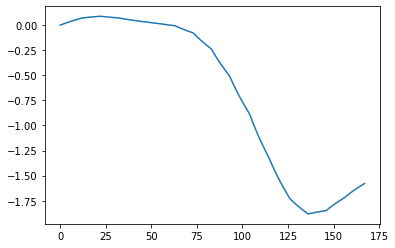

In [147]:
plt.plot(ret.yaw)

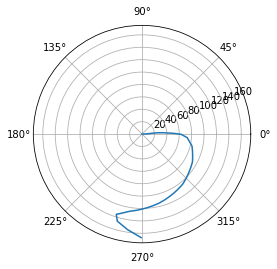

In [148]:
plt.clf()
sp = plt.subplot(1, 1, 1, projection='polar')
sp.set_theta_zero_location('E')
# sp.set_theta_direction(-1)
plt.plot(ret.yaw,[i for i in range(len(ret.yaw))])
plt.show()

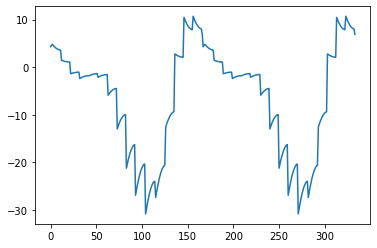

In [149]:
di_arr=[i*180/math.pi for i in di_arr]
plt.plot(di_arr)

In [150]:
joblib.dump({
'x':cx,"y":cy},
"path.z")

['path.z']

In [62]:
cx

[0.43333333333333335,
 0.7334782167192219,
 1.0327789026366971,
 1.3304090181131871,
 1.6273122715012551,
 1.9276796040349833,
 2.2357436727832916,
 2.5473493531490745,
 2.849128703940845,
 3.1272422346075093,
 3.3650246431161848,
 3.514789492251189,
 3.5330685683813887,
 3.4763725958632294,
 3.422491394198657,
 3.3952757765637904,
 3.38832117201392,
 3.3948885479970725,
 3.4082388719612755]

In [63]:
cy

[5.375,
 5.399206687172543,
 5.420777729826494,
 5.437096730434421,
 5.447458635270175,
 5.454664770993198,
 5.461396724255643,
 5.456763260609604,
 5.414965281234685,
 5.309440642282311,
 5.117332536650728,
 4.856460526791408,
 4.565010233123334,
 4.261050571123405,
 3.956337449625672,
 3.6546373612678087,
 3.3552354477843,
 3.057367311303062,
 2.760268553952013]

In [92]:
# hmm=[(0.35, 5.2, 0.0), (0.35, 5.2, 0.0), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, 0.0011111111380159853), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, 0.0), (0.35, 5.2, 0.0), (0.35, 5.2, 0.0), (0.35, 5.2, 0.0), (0.35, 5.2, 0.0), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.0009630362140103581), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.0009630362140103581), (0.37, 5.29, 3.141592653589793), (0.37, 5.29, 0.0011111111380159853), (0.37, 5.28, 0.02666666731238365), (0.37, 5.28, 0.02222222276031971), (0.37, 5.28, -0.01874095598329709), (0.37, 5.28, -0.0531852881061004), (0.37, 5.28, 3.141592653589793), (0.4, 5.3, -0.09540731111635382), (0.39, 5.2, 3.141592653589793), (0.4, 5.22, 3.141592653589793), (0.41, 5.21, -0.13318521181215495), (0.44, 5.21, 3.141592653589793), (0.46, 5.21, -0.16985208192934173), (0.48, 5.21, 3.141592653589793), (0.5, 5.2, 3.141592653589793), (0.52, 5.2, -0.20540744463075838), (0.54, 5.2, 3.141592653589793), (0.57, 5.19, -0.17096311250795507), (0.6, 5.18, -0.16985208192934173), (0.62, 5.17, -0.2165187040912073), (0.66, 5.16, -0.2431853453265585), (0.69, 5.16, -0.28874093690981073), (0.73, 5.16, -0.33429652849306296), (0.77, 5.15, 3.141592653589793), (0.8, 5.14, 3.141592653589793), (0.82, 5.13, -0.35429650941957636), (0.86, 5.11, -0.35429650941957636), (0.88, 5.1, -0.35429650941957636), (0.9, 5.09, 3.141592653589793), (0.91, 5.09, -0.35429650941957636), (0.91, 5.09, -0.35429650941957636), (0.91, 5.09, -0.35429650941957636), (0.91, 5.09, -0.35429650941957636), (0.91, 5.09, 3.141592653589793), (0.91, 5.09, -0.35429650941957636), (0.91, 5.09, 3.141592653589793), (0.91, 5.09, 3.141592653589793), (0.91, 5.09, -0.33762962022890297), (0.91, 5.09, 3.141592653589793), (0.91, 5.08, -0.2942965666400352), (0.9, 5.09, 3.141592653589793), (0.92, 5.09, -0.25874072710146173), (0.94, 5.08, 3.141592653589793), (0.96, 5.08, -0.2642963568316862), (0.99, 5.08, -0.24540740648378515), (1.04, 5.07, -0.19651872316469393), (1.07, 5.07, -0.2787407080279751), (1.11, 5.06, -0.3654072920428675), (1.11, 5.06, 3.141592653589793), (1.13, 5.06, 3.141592653589793), (1.16, 5.06, -0.43762952486147094), (1.2, 5.05, -0.4609630743609831), (1.29, 5.02, -0.4831851164447231), (1.34, 5.0, -0.5154073874102988), (1.37, 4.98, -0.5654075781451622), (1.39, 4.96, -0.62429649034609), (1.42, 4.94, -0.6642964521991178), (1.42, 4.94, -0.7342966238604945), (1.42, 4.94, -0.7998521963702602), (1.44, 4.92, -0.8554075399981902), (1.45, 4.93, 3.141592653589793), (1.46, 4.91, -0.9076297918902793), (1.49, 4.87, 3.141592653589793), (1.52, 4.84, -0.966518704091207), (1.56, 4.83, -1.0254076162921348), (1.59, 4.78, -1.0887406508075161), (1.62, 4.76, -1.1265185515033171), (1.63, 4.73, -1.1387408415423794), (1.65, 4.69, 3.141592653589793), (1.68, 4.67, 3.141592653589793), (1.69, 4.65, -1.1365187803851529), (1.69, 4.62, 3.141592653589793), (1.72, 4.58, -1.1542962233172818), (1.73, 4.53, 3.141592653589793), (1.75, 4.51, -1.1254075209247036), (1.76, 4.46, 3.141592653589793), (1.76, 4.42, 3.141592653589793), (1.77, 4.4, -1.093185249959127), (1.77, 4.37, 3.141592653589793), (1.8, 4.32, -1.1265185515033171), (1.82, 4.28, 3.141592653589793), (1.85, 4.21, 3.141592653589793), (1.89, 4.11, -1.0754073301898404), (1.91, 4.04, 3.141592653589793), (1.93, 3.99, -1.028740708027975), (1.95, 3.95, 3.141592653589793), (1.97, 3.94, -0.9620741049395959), (1.97, 3.93, 3.141592653589793), (1.98, 3.9, 3.141592653589793), (2.01, 3.86, -0.9720743338214315), (2.03, 3.82, -0.9709633032428182), (2.07, 3.77, -0.925407711659567), (2.15, 3.67, -0.9487407843219203), (2.19, 3.64, -1.0054076353656216), (2.23, 3.6, 3.141592653589793), (2.25, 3.52, -1.074296299611227), (2.29, 3.47, 3.141592653589793), (2.32, 3.44, -1.1665185133563438), (2.35, 3.43, 3.141592653589793), (2.34, 3.42, 3.141592653589793), (2.34, 3.42, -1.2320740858661094), (2.34, 3.38, 3.141592653589793), (2.39, 3.28, -1.2742965857135218), (2.4, 3.23, 3.141592653589793), (2.4, 3.18, -1.3031852881060997), (2.41, 3.15, 3.141592653589793), (2.41, 3.11, 3.141592653589793), (2.4, 3.1, -1.3320739904986785), (2.4, 3.08, 3.141592653589793), (2.4, 3.05, -1.3654072920428675), (2.4, 3.04, 3.141592653589793), (2.4, 3.04, 3.141592653589793), (2.41, 2.98, -1.4487407843219198), (2.42, 2.95, 3.141592653589793), (2.41, 2.9, -1.5287407080279753), (2.42, 2.85, 3.141592653589793), (2.4, 2.8, -1.617629830037252)]
hmm=[(0.31, 5.19, 0.0), (0.31, 5.19, 0.0), (0.31, 5.19, 3.141592653589793), (0.32, 5.19, 0.0), (0.31, 5.19, 3.141592653589793), (0.31, 5.2, 3.141592653589793), (0.31, 5.19, 0.0033333334140479565), (0.32, 5.2, 0.015379225727319605), (0.31, 5.2, 0.014268195148706277), (0.31, 5.2, 0.014268195148706277), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 3.141592653589793), (0.32, 5.19, 0.014268195148706277), (0.32, 5.19, 3.141592653589793), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 3.141592653589793), (0.32, 5.19, 0.014268195148706277), (0.32, 5.19, 3.141592653589793), (0.32, 5.19, 0.014268195148706277), (0.32, 5.2, 0.014268195148706277), (0.32, 5.19, 3.141592653589793), (0.32, 5.2, 0.014268195148706277), (0.32, 5.19, 0.0011111111380159853), (0.32, 5.19, 0.016490256305932937), (0.32, 5.19, 0.014268195148706277), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 0.0011111111380159853), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 3.141592653589793), (0.32, 5.19, 0.0011111111380159853), (0.32, 5.19, 3.141592653589793), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 0.0011111111380159853), (2.95, 3.56, 3.141592653589793), (2.36, 3.08, 0.0011111111380159853), (1.86, 3.04, 3.141592653589793), (0.33, 5.22, 0.0011111111380159853), (0.33, 5.22, 0.0033333334140479565), (0.33, 5.23, 0.0033333334140479565), (0.37, 5.24, 0.03222222253680229), (0.42, 5.21, 0.14777778089046478), (0.5, 5.21, 3.141592653589793), (0.58, 5.22, 0.25555557012557983), (0.64, 5.23, 3.141592653589793), (0.72, 5.25, 0.3466666638851166), (0.8, 5.28, 0.2611111104488373), (0.92, 5.33, 0.3655555546283722), (1.0, 5.37, 0.49444442987442017), (1.07, 5.42, 0.6100000143051147), (1.14, 5.44, 0.5922222137451172), (1.23, 5.47, 0.6000000238418579), (1.31, 5.51, 0.7477777600288391), (1.37, 5.55, 0.8666666746139526), (1.43, 5.6, 0.9055555462837219), (1.49, 5.64, 1.0444444417953491), (1.55, 5.71, 1.1622222661972046), (1.62, 5.75, 1.2688888311386108), (1.7, 5.8, 1.3744444847106936), (1.8, 5.83, 1.4822221994400024), (1.85, 5.86, 1.5833333730697632), (1.9, 5.9, 1.6977777481079102), (1.95, 5.93, 1.8088889122009277), (0.18, 3.41, 1.9222222566604614), (2.23, 3.85, 2.035555601119995)]
# hmm=[(0.62, 5.25, 0.0), (0.62, 5.25, 0.016490256305932937), (0.62, 5.25, 3.141592653589793), (0.62, 5.25, 0.006666666828095913), (0.62, 5.25, 0.0811111107468605), (0.62, 5.25, 0.1644444465637207), (0.64, 5.25, 0.22333332896232605), (0.69, 5.25, 0.1455555558204651), (0.75, 5.26, 0.058888889849185944), (0.8, 5.26, -0.01239844608664491), (0.85, 5.28, -0.10795422840476052), (0.9, 5.3, 3.141592653589793), (0.95, 5.32, 3.141592653589793), (1.0, 5.33, -0.20239850330710402), (1.05, 5.33, 3.141592653589793), (1.1, 5.33, -0.1579544191396239), (1.15, 5.33, 3.141592653589793), (1.21, 5.32, -0.08239861774802168), (1.26, 5.31, 3.141592653589793), (1.3, 5.29, 3.141592653589793), (1.35, 5.28, -0.03350993442893044), (1.4, 5.26, 3.141592653589793), (1.44, 5.26, -0.025732243541479308), (1.49, 5.25, 3.141592653589793), (1.53, 5.26, 0.012222222052514553), (1.58, 5.27, 3.141592653589793), (1.62, 5.26, 3.141592653589793), (1.68, 5.28, 0.08777777850627898), (1.72, 5.26, 0.12444444745779037), (1.77, 5.27, 3.141592653589793), (1.81, 5.28, 0.12666666507720947), (1.86, 5.28, 0.13333334028720856), (1.9, 5.3, 0.19777777791023254), (1.96, 5.31, 0.20888888835906982), (2.0, 5.32, 3.141592653589793), (2.04, 5.33, 0.20666666328907013), (2.09, 5.33, 0.2544444501399994), (2.13, 5.34, 0.25111111998558044), (2.18, 5.35, 0.21666666865348816), (2.23, 5.37, 0.15000000596046448), (2.27, 5.38, 0.12222222238779068), (2.32, 5.39, 0.03444444388151169), (2.36, 5.4, -0.03462096500754377), (2.45, 5.42, 3.141592653589793), (2.49, 5.44, -0.12350961017966279), (2.58, 5.45, 3.141592653589793), (2.63, 5.46, 3.141592653589793), (2.71, 5.46, -0.21795436191916404), (2.77, 5.47, -0.25239869404196735), (2.85, 5.45, -0.18239852238059062), (2.89, 5.46, -0.10906525898337385), (2.94, 5.43, -0.03462096500754377), (2.98, 5.41, 0.025555554777383804), (3.02, 5.4, 3.141592653589793), (3.07, 5.38, 3.141592653589793), (3.1, 5.35, 0.09777777642011642), (3.15, 5.34, 3.141592653589793), (3.19, 5.34, 0.1733333319425583), (3.23, 5.35, 3.141592653589793), (3.28, 5.34, 0.25), (3.32, 5.35, 0.2477777749300003), (3.35, 5.35, 0.2522222101688385), (3.4, 5.35, 0.2522222101688385), (3.45, 5.36, 0.2522222101688385), (3.49, 5.37, 3.141592653589793), (3.54, 5.38, 0.25333333015441895), (3.58, 5.39, 3.141592653589793), (3.61, 5.41, 0.22777777910232544), (3.65, 5.42, 3.141592653589793), (3.71, 5.44, 0.21666666865348816), (3.73, 5.44, 0.2855555415153503), (3.72, 5.44, 0.3566666543483734), (3.73, 5.44, 0.42888888716697693), (3.72, 5.44, 0.49888888001441956), (3.72, 5.44, 3.141592653589793), (3.72, 5.44, 3.141592653589793), (3.73, 5.44, 0.5522222518920898), (3.72, 5.44, 0.4677777886390686), (3.73, 5.44, 0.4011111259460449), (3.77, 5.46, 0.3477777838706971), (3.82, 5.46, 0.4011111259460449), (3.86, 5.45, 3.141592653589793), (3.89, 5.46, 3.141592653589793), (3.93, 5.5, 0.47333332896232605), (3.98, 5.51, 0.4977777898311615), (4.0, 5.51, 0.48444443941116333), (4.04, 5.55, 0.47999998927116394), (4.07, 5.57, 0.5166666507720947), (4.09, 5.58, 0.5522222518920898), (4.14, 5.62, 0.5688889026641845), (4.16, 5.63, 0.5922222137451172), (4.2, 5.65, 0.6222222447395325), (4.24, 5.66, 0.6744444370269775)]
# hmm=[(0.72, 5.25, 0.0), (0.72, 5.25, 0.006490027424097334), (0.72, 5.25, 0.006490027424097334), (0.72, 5.26, -0.07684298801779721), (0.72, 5.25, -0.07684298801779721), (0.72, 5.26, -0.07684298801779721), (0.72, 5.26, -0.14462109852194732), (0.76, 5.26, -0.14462109852194732), (0.8, 5.25, -0.23128768253684065), (0.85, 5.24, -0.23128768253684065), (0.9, 5.22, -0.32573195743918415), (0.95, 5.2, -0.32573195743918415), (1.0, 5.18, -0.32573195743918415), (1.05, 5.16, -0.41239854145407645), (1.09, 5.12, -0.41239854145407645), (1.12, 5.1, -0.5023986940419676), (1.17, 5.07, -0.5023986940419676), (1.2, 5.03, -0.5468432550466056), (1.24, 5.0, -0.5468432550466056), (1.24, 5.0, -0.6068431978261467), (1.27, 4.98, -0.6068431978261467), (1.32, 4.93, -0.6068431978261467), (1.34, 4.9, -0.6857320909535879), (1.38, 4.86, -0.6857320909535879), (1.38, 4.86, -0.7479540948903557), (1.4, 4.82, -0.7479540948903557), (1.43, 4.78, -0.8479539995229247), (1.44, 4.75, -0.8479539995229247), (1.44, 4.75, -0.9401766901051993), (1.46, 4.69, -0.9401766901051993), (1.48, 4.65, -0.9401766901051993), (1.49, 4.61, -1.0268432741200928), (1.49, 4.61, -1.0268432741200928), (1.5, 4.57, -1.116842949870825), (1.5, 4.51, -1.116842949870825), (1.51, 4.48, -1.210176671031713), (1.5, 4.42, -1.210176671031713), (1.5, 4.42, -1.3023988847768309), (1.51, 4.38, -1.3023988847768309), (1.51, 4.33, -1.3023988847768309), (1.51, 4.28, -1.3935095911061763), (1.49, 4.23, -1.3935095911061763), (1.49, 4.23, -1.48462077427268), (1.5, 4.19, -1.48462077427268), (1.49, 4.14, -1.48462077427268), (1.47, 4.09, -1.5768429880177979), (1.46, 4.05, -1.5579540376698968), (1.46, 4.01, -1.4835097436940667), (1.47, 3.95, -1.406842911723852), (1.48, 3.92, -1.3323986177480218), (1.48, 3.87, -1.3323986177480218), (1.5, 3.82, -1.2612874155080318), (1.5, 3.78, -1.2612874155080318), (1.51, 3.73, -1.199065411571264), (1.53, 3.68, -1.280176365855932), (1.54, 3.65, -1.3690654878652098), (1.57, 3.61, -1.4579541330373287), (1.57, 3.57, -1.545732224467992), (1.58, 3.52, -1.545732224467992), (1.58, 3.47, -1.6357319002187245), (1.57, 3.42, -1.6357319002187245), (1.57, 3.38, -1.6479541902577877), (1.55, 3.34, -1.6479541902577877), (1.54, 3.29, -1.6479541902577877), (1.53, 3.24, -1.5757319574391846), (1.51, 3.2, -1.5757319574391846), (1.49, 3.15, -1.5646206979787343), (1.49, 3.11, -1.5646206979787343), (1.5, 3.06, -1.5646206979787343), (1.5, 3.0, -1.6479541902577877), (1.5, 2.97, -1.7146207933461666), (1.5, 2.92, -1.7112877016103267), (1.46, 2.88, -1.6423985605275635), (1.48, 2.85, -1.5701763277089589), (1.45, 2.8, -1.5168430452382564), (1.43, 2.76, -1.563509667400121), (1.42, 2.73, -1.6546208505666256), (1.42, 2.67, -1.6546208505666256), (1.4, 2.62, -1.7468430643117425), (1.42, 2.58, -1.7468430643117425), (1.43, 2.53, -1.7468430643117425), (1.42, 2.49, -1.7601763849294179)]

In [151]:
hmm=[(0.74, 5.29, 0.0, 21), (0.74, 5.28, 0.0011111111380159855, 21), (0.75, 5.29, -0.08540755907167608, 21), (0.77, 5.29, -0.13762981096376592, 21), (0.8, 5.29, -0.20207435289491826, 21), (0.84, 5.3, -0.28874093690981084, 21), (0.9, 5.3, -0.36762983003725225, 21), (0.95, 5.3, -0.36762983003725225, 21), (1.0, 5.29, -0.36762983003725225, 21), (1.02, 5.29, -0.45318538347353154, 21), (1.05, 5.27, -0.45318538347353154, -21), (1.1, 5.26, -0.45318538347353154, 21), (1.14, 5.25, -0.5476296583758753, 21), (1.18, 5.23, -0.5476296583758753, 21), (1.23, 5.21, -0.6142962614642542, 21), (1.26, 5.19, -0.6142962614642542, 21), (1.3, 5.16, -0.6698520819293421, 21), (1.33, 5.13, -0.6698520819293421, 21), (1.39, 5.1, -0.6698520819293421, 21), (1.43, 5.07, -0.7654073874102991, 21), (1.47, 5.03, -0.8531854788409632, 21), (1.52, 4.99, -0.9365184942828577, 21), (1.55, 4.95, -0.9942963759051722, 21), (1.61, 4.88, -1.0531852881061, 21), (1.62, 4.83, -1.1287410894977015, 21), (1.67, 4.76, -1.1287410894977015, 21), (1.67, 4.72, -1.194296185170308, 21), (1.7, 4.67, -1.194296185170308, 21), (1.7, 4.63, -1.194296185170308, 21), (1.71, 4.57, -1.2442963759051713, 21), (1.7, 4.53, -1.2442963759051713, 21), (1.72, 4.5, -1.2931855360614222, 21), (1.73, 4.45, -1.3331854979144495, 21), (1.75, 4.36, -0.0011111111380159855, 21), (1.75, 4.29, -1.4154074827777308, 21), (1.77, 4.22, -1.4987409750567835, -9.922388816409002), (1.77, 4.17, -1.5020740667926233, -13.107284281959068), (1.77, 4.12, -1.5020740667926233, -11.922979280907875), (1.76, 4.06, -1.4409630934344682, 8.24405348911539), (1.77, 4.01, -1.4409630934344682, 9.541012017123697), (1.77, 3.93, -1.4409630934344682, 11.023122623188872), (1.77, 3.85, -1.4431851545916956, 11.748064460156964), (1.8, 3.8, -1.4431851545916956, 7.056858894220081), (1.8, 3.73, -1.5231850782977494, -13.202121037237001), (1.81, 3.63, -1.5231850782977494, -15.509727756569115), (1.8, 3.58, -1.5365188757525843, -16.598442292058948), (1.8, 3.52, -1.5365188757525843, -16.115472347309357), (1.8, 3.51, -1.5365188757525843, -15.980228460603527), (1.8, 3.46, -1.455407444630758, 6.359798026541473), (1.83, 3.35, -1.4542964140521448, 5.9627847059667785), (1.83, 3.27, -1.5065186659442338, -7.148779262550081), (1.84, 3.13, -1.5187409559832972, -11.232244880323833), (1.82, 3.08, -1.5187409559832972, -8.537854043227647), (1.83, 3.06, -1.5209630171405237, -10.120036366709115), (1.83, 3.06, -1.5209630171405237, -10.168324399830949), (1.85, 3.01, -1.5209630171405237, 21), (1.85, 3.01, -1.5198519865619105, 21), (1.84, 2.9, -1.5198519865619105, 21), (1.82, 2.81, -1.6265185515033167, -2.2473347648055753), (1.82, 2.81, -1.6265185515033167, -4.3883213862953605), (1.8, 2.7, -1.7031853834735315, -21), (1.8, 2.63, -1.6898520628558558, -20.77861865157149), (1.8, 2.5, -1.582073990498678, 7.2937779808710825), (1.81, 2.42, -1.4809630552874964, 21), (1.83, 2.32, -1.510963265095846, 21), (1.83, 2.23, -1.6320741812335413, -6.938942894148588), (1.82, 2.16, -1.7354076544391077, -21), (1.8, 2.12, -1.8120740095721644, -21), (1.78, 2.08, -1.7209633032428187, -21), (1.76, 2.02, -1.7209633032428187, -21), (1.75, 1.98, -1.7209633032428187, -21), (1.73, 1.93, -1.6254075209247034, -1.0100977045266426), (1.73, 1.85, -1.6254075209247034, 0.04988494409432147), (1.74, 1.82, -1.5220740477191361, 21), (1.74, 1.75, -1.5220740477191361, 21), (1.75, 1.68, -1.5520742575274866, 18.542755283158918), (1.76, 1.65, -1.6720741430865687, -14.411921381637327), (1.76, 1.58, -1.7754076162921342, -21), (1.75, 1.48, -1.8765185515033167, -21), (1.75, 1.43, -1.8976295630084437, -21), (1.73, 1.4, -1.8976295630084437, -21), (1.71, 1.32, -1.8031852881061, -21), (1.7, 1.3, -1.8031852881061, -21), (1.65, 1.25, -1.7109630743609818, -21), (1.63, 1.21, -1.7109630743609818, -19.195221186727753), (1.62, 1.15, -1.7109630743609818, -18.844618771634796), (1.6, 1.1, -1.6176298300372522, 6.895110294770301), (1.61, 1.04, -1.6176298300372522, 7.06687864024255), (1.59, 0.99, -1.613185230885641, 9.265117966893476)]

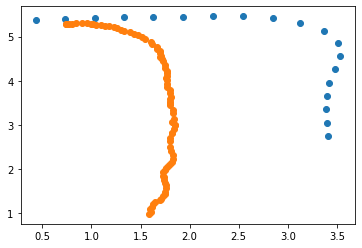

In [152]:
plt.scatter(cx,cy)

rx,ry=[i[0] for i in hmm],[i[1] for i in hmm]
plt.scatter(rx,ry)

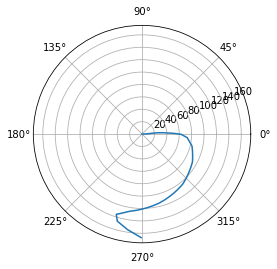

In [153]:
plt.clf()
sp = plt.subplot(1, 1, 1, projection='polar')
sp.set_theta_zero_location('E')
# sp.set_theta_direction(-1)
plt.plot(ret.yaw,[i for i in range(len(ret.yaw))])
plt.show()

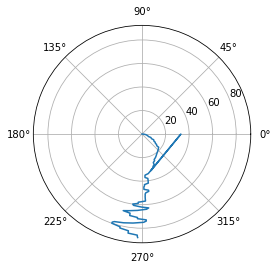

In [154]:
ryaw=[i[2] for i in hmm]
plt.clf()
sp = plt.subplot(1, 1, 1, projection='polar')
sp.set_theta_zero_location('E')
# sp.set_theta_direction(-1)
plt.plot(ryaw,[i for i in range(len(ryaw))])
plt.show()

Text(0.5, 1.0, 'raspi-yaw in radians')

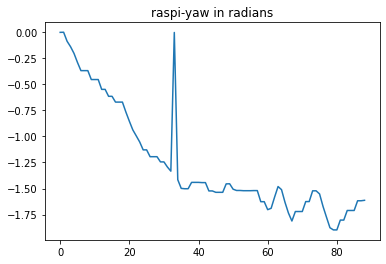

In [155]:
plt.plot(ryaw)
plt.title("raspi-yaw in radians")

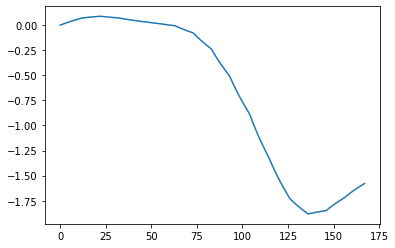

In [156]:
plt.plot(ret.yaw)

In [157]:
a=max(ryaw)

In [158]:
a > 3.14

False

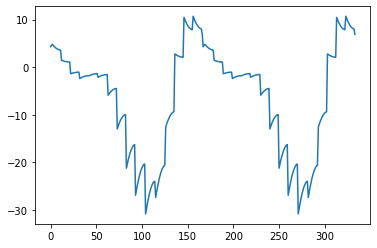

In [159]:
plt.plot(di_arr)

In [160]:
ster_ang=[i[3] for i in hmm]

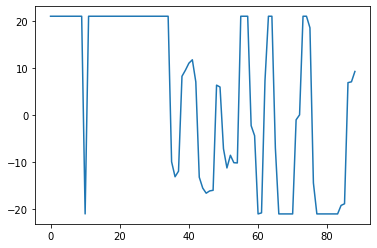

In [161]:
plt.plot(ster_ang)